In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


PROBLEM STATEMENT

The speech signal contains a vast spectrum of information about the speaker such as speaker’s gender, age, accent, or health state. Gender, age, and emotion detection from the speech are essential in machine and human interaction. Sometimes it is required to predict age, gender and emotion from audio clips for investigation purposes. Most telecommunication companies need to analyze audio calls to predict customer demography and recommend offers based on demographic segments. In business analysis of speech during a conversation helps the organization to find the attitude,sentiment, opinion and emotion of the conversation. It can positively impact on customer relation of the organization. With the increase in use of social media like twitter, YouTube audio data is rapidly increasing in its volume.The purpose of this project is to develop a model to detect gender, age and emotion from audio speech. Our model is based on RNN(Recurrent neural networks) and MLP(multilayer perceptron).

PRE PROCESSING

In [ ]:
#Import All Important Libraries
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files
import librosa
import soundfile
import os, glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

!pip install pydub
from pydub import AudioSegment

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)

In [ ]:
RAV = '/content/drive/MyDrive/Colab Notebooks/Neural Networks and Deep Learning/Case study/Dataset/RAVDESS Dataset/'

In [ ]:
dir_list = os.listdir(RAV)
dir_list.sort()

In [ ]:
def extract_feature(file_name, mfcc, chroma, mel):
  with soundfile.SoundFile(file_name) as sound_file:
    X = sound_file.read(dtype="float32")
    sample_rate=sound_file.samplerate
    if chroma:
      stft=np.abs(librosa.stft(X))
    result=np.array([])
    if mfcc:
      mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
      result=np.hstack((result, mfccs))
    if chroma:
      chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
      result=np.hstack((result, chroma))
    if mel:
      mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
      result=np.hstack((result, mel))
  return result

In [ ]:
emotions = []
gender = []
features = []

for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
      part = f.split('.')[0].split('-')
      emotions.append(int(part[2]))
      temp = int(part[6])
      if temp % 2 == 0:
          temp = "female"
      else:
          temp = "male"
      gender.append(temp)
      features.append(extract_feature((RAV + i + '/' + f), mfcc = True, chroma = True, mel = True))

In [ ]:
RAV_df = pd.DataFrame(emotions)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df_new = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df_new['labels'].value_counts()

male_calm          96
male_happy         96
male_sad           96
male_disgust       96
male_surprise      96
male_angry         96
male_fear          96
female_calm        96
female_happy       96
female_angry       96
female_fear        96
female_sad         96
female_disgust     96
female_surprise    96
male_neutral       48
female_neutral     48
Name: labels, dtype: int64

In [ ]:
RAV_df

,gender,emotion,labels
0,male,calm,male_calm
1,male,calm,male_calm
2,male,neutral,male_neutral
3,male,neutral,male_neutral
4,male,calm,male_calm
...,...,...,...
1435,female,surprise,female_surprise
1436,female,disgust,female_disgust
1437,female,disgust,female_disgust
1438,female,surprise,female_surprise


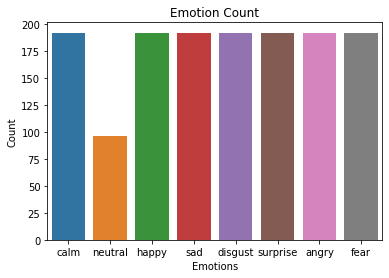

In [ ]:
sns.countplot(RAV_df.emotion)
plt.title('Emotion Count')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show();

In [ ]:
RAV_df = pd.concat([RAV_df, pd.DataFrame(features)], axis=1)
RAV_df

,gender,emotion,labels,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,male,calm,male_calm,-759.917847,75.788948,6.028998,14.562723,6.459432,14.636641,-2.999552,4.625813,-5.195350,-0.702961,-7.786034,-3.560928,2.184742,-1.828896,-0.347037,0.832212,-2.520894,-0.658892,2.920049,-1.937435,-3.031794,-0.292167,-0.244068,-0.540124,-2.956580,-2.104136,-1.400510,-0.925955,-3.723610,-1.993220,0.205182,-2.190074,-2.837190,0.461874,-1.021207,-1.413634,0.348101,...,0.000007,0.000006,0.000006,0.000006,0.000005,0.000007,0.000005,0.000003,0.000004,0.000004,0.000005,0.000006,0.000003,0.000004,0.000004,0.000004,0.000003,0.000004,0.000004,0.000002,0.000002,1.728236e-06,1.289864e-06,1.278671e-06,8.758655e-07,7.264676e-07,4.894324e-07,3.679957e-07,2.989512e-07,1.622806e-07,1.376438e-07,1.088035e-07,9.219798e-08,5.054346e-08,3.130356e-08,1.891648e-08,1.093055e-08,6.907234e-09,5.929377e-09,5.490418e-09
1,male,calm,male_calm,-735.006592,79.093056,8.141059,11.413560,5.174132,15.393293,-2.752063,2.964593,-5.388961,-1.691822,-5.852824,-4.043277,3.004652,-1.036605,-0.067745,0.088225,-2.209570,-1.455965,2.568242,-1.596300,-2.678672,-1.410864,0.118917,-0.127252,-2.847892,-1.771579,-1.886281,-0.791153,-3.215482,-2.180906,0.241240,-2.247438,-2.220091,-0.249406,-0.975884,-0.955849,-0.259040,...,0.000007,0.000004,0.000003,0.000003,0.000005,0.000004,0.000003,0.000003,0.000003,0.000004,0.000004,0.000003,0.000004,0.000006,0.000007,0.000007,0.000006,0.000004,0.000002,0.000002,0.000001,9.713349e-07,9.564819e-07,8.252334e-07,9.683692e-07,1.230503e-06,8.033527e-07,3.595680e-07,2.898434e-07,2.569258e-07,7.811629e-08,4.128243e-08,3.126313e-08,2.750857e-08,1.755317e-08,9.856551e-09,8.679062e-09,7.096063e-09,5.672045e-09,5.365027e-09
2,male,neutral,male_neutral,-726.217224,68.541420,3.293398,12.205300,5.510278,13.667410,-2.983829,3.098029,-3.310813,-1.564384,-7.861652,-2.124282,2.849204,-2.667806,0.959020,1.628167,-2.736689,0.254241,2.675377,-1.761165,-1.886474,-0.975620,-0.379437,0.400273,-3.044044,-2.901258,-0.109248,-0.863565,-3.333269,-1.978465,0.457081,-1.399109,-2.926855,0.013957,-0.490734,-0.570905,0.040399,...,0.000005,0.000004,0.000004,0.000005,0.000006,0.000004,0.000002,0.000003,0.000003,0.000003,0.000002,0.000002,0.000004,0.000006,0.000006,0.000005,0.000004,0.000003,0.000003,0.000002,0.000002,1.923959e-06,1.562696e-06,1.155648e-06,1.236189e-06,2.178529e-06,1.341962e-06,8.759328e-07,7.719471e-07,5.428048e-07,3.798515e-07,2.659118e-07,1.358990e-07,6.421450e-08,4.124923e-08,2.838078e-08,2.313626e-08,1.160476e-08,5.817900e-09,5.362134e-09
3,male,neutral,male_neutral,-710.959839,67.579185,5.783356,13.227695,6.194669,12.640195,-1.662046,5.663977,-4.953693,-3.484669,-7.417325,-1.927515,2.282990,-0.607773,0.171210,1.393946,-2.386732,-0.657544,1.749457,-0.492133,-3.015615,-0.982296,0.533741,0.270409,-2.364810,-2.673702,-1.400937,-0.044098,-2.158159,-1.575089,-0.402906,-1.325091,-2.506733,-0.183847,-0.639693,-0.547448,0.465640,...,0.000019,0.000013,0.000025,0.000033,0.000022,0.000022,0.000022,0.000012,0.000013,0.000015,0.000016,0.000048,0.000038,0.000030,0.000032,0.000029,0.000036,0.000021,0.000021,0.000019,0.000013,1.280474e-05,1.415233e-05,1.000641e-05,7.165249e-06,6.465661e-06,3.736069e-06,3.681650e-06,2.499252e-06,1.950656e-06,1.410576e-06,1.025075e-06,9.816289e-07,1.029304e-06,5.594787e-07,2.913279e-07,1.172367e-07,4.114702e-08,7.315270e-09,5.706893e-09
4,male,calm,male_calm,-733.524902,81.589859,4.863358,14.423687,5.267689,13.968560,-3.085617,7.173246,-4.821438,-0.967449,-6.250473,-3.866640,3.325519,-1.668072,1.981391,0.965025,-2.970167,0.925096,2.661871,-2.686702,-4.089703,-1.142779,-0.041476,0.639604,-4.437098,-1.978665,-1.668379,-0.129616,-2.648198,-1.740780,-0.243150,-1.499499,-3.442183,1.079488,-1.840691,-1.141296,-0.546892,...,0.000034,0.0000

Each of the 1440 feature arrays has 180 features composed of 12 chromagram pitch classes + 128 mel spectrogram bands + 40 MFC coefficients.

In [ ]:
RAV_df.isnull().values.any()

False

In [ ]:
le = LabelEncoder()

RAV_df['emotion']= le.fit_transform(RAV_df['emotion'])

In [ ]:
X = RAV_df.drop(['gender', 'emotion', 'labels'], axis = 1)
y = RAV_df['emotion']

In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape)

(1152, 180) (288, 180)


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
from matplotlib.pyplot import specgram
import pandas as pd
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import seaborn as sns

In [ ]:
# MALE NEUTRAL
fname1=RAV+'Actor_01/03-01-01-01-01-01-01.wav'
data, sr = librosa.load(fname1)
ipd.Audio(fname1)

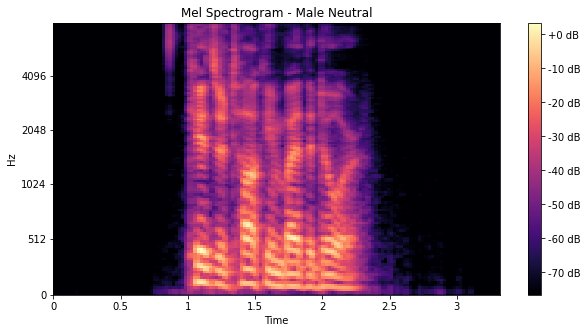

In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Neutral')
plt.colorbar(format='%+2.0f dB');

In [ ]:
# FEMALE NEUTRAL
fname2=RAV+'Actor_14/03-01-01-01-01-01-14.wav'
data, sr = librosa.load(fname2)
ipd.Audio(fname2)


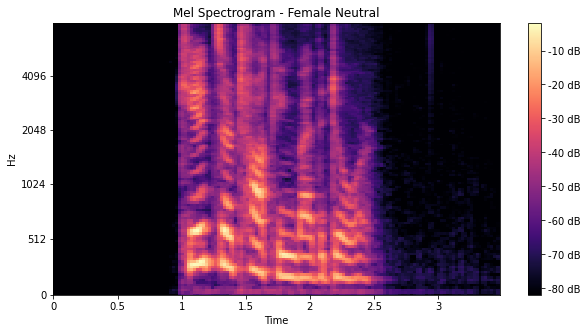

In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Neutral')
plt.colorbar(format='%+2.0f dB');


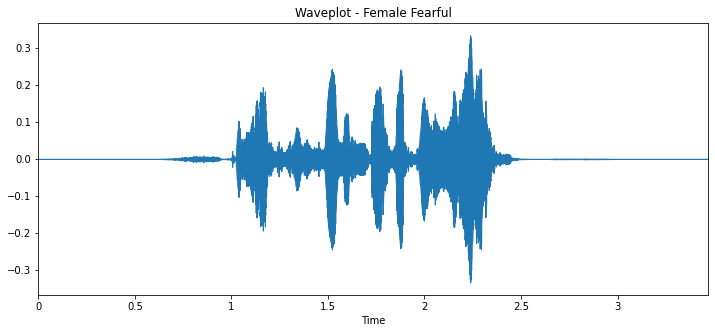

In [ ]:
fname3 = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'
data, sr = librosa.load(fname3)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(data, sr=sr)
plt.title('Waveplot - Female Fearful')
# Lets play the audio
ipd.Audio(fname3)

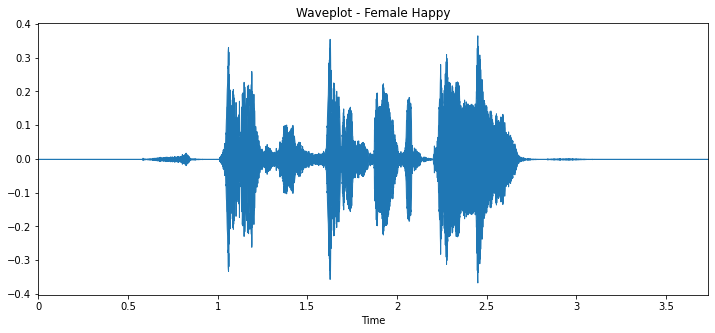

In [ ]:
# Pick a happy track
fname4 = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'
data, sr = librosa.load(fname4)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(data, sr=sr)
plt.title('Waveplot - Female Happy')

# Lets play the audio
ipd.Audio(fname4)

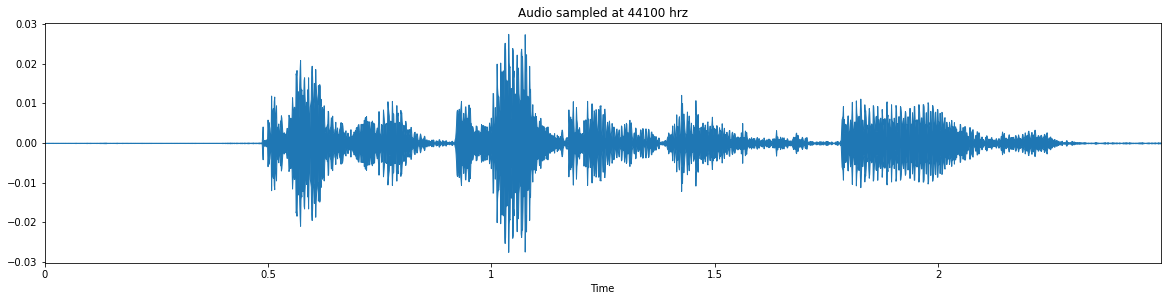

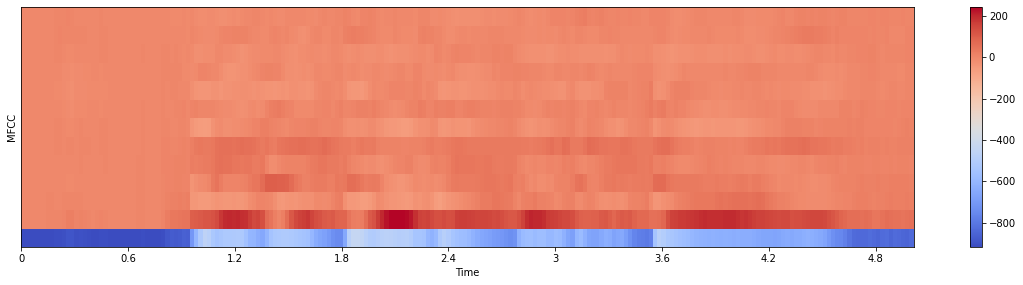

In [ ]:
path = RAV + 'Actor_09/03-01-05-01-01-01-09.wav'
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

EMOTION PREDICTION -MODEL CREATION

In [ ]:
Model = Sequential()

Model.add(Dense(60, input_shape = (X_train.shape[1],), activation = 'relu', kernel_initializer = 'he_normal'))
Model.add(Dropout(0.3))
Model.add(BatchNormalization())
Model.add(Dense(80, activation = 'relu', kernel_initializer = 'he_normal'))
Model.add(Dropout(0.3))
Model.add(BatchNormalization())
Model.add(Dense(120, activation = 'relu', kernel_initializer = 'he_normal'))
Model.add(Dropout(0.3))
Model.add(BatchNormalization())
Model.add(Dense(70, activation = 'relu', kernel_initializer = 'he_normal'))
Model.add(Dropout(0.3))
Model.add(BatchNormalization())
Model.add(Dense(10, activation = 'softmax', kernel_initializer = 'he_normal'))

Model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 60)                10860     
                                                                 
 dropout_54 (Dropout)        (None, 60)                0         
                                                                 
 batch_normalization_54 (Bat  (None, 60)               240       
 chNormalization)                                                
                                                                 
 dense_67 (Dense)            (None, 80)                4880      
                                                                 
 dropout_55 (Dropout)        (None, 80)                0         
                                                                 
 batch_normalization_55 (Bat  (None, 80)               320       
 chNormalization)                                    

In [ ]:
Model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
              loss='sparse_categorical_crossentropy',     # Multiclass classification
              metrics=['accuracy'])

In [ ]:
earlyStopping = callbacks.EarlyStopping(monitor='loss', patience=5)

chkpnt_path = 'Model/Model_checkpoint'
modelCheckpoint = callbacks.ModelCheckpoint(
    filepath = chkpnt_path,
    save_weights_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True
)

In [ ]:
history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, verbose = 1, validation_split = 0.2, callbacks = [earlyStopping, modelCheckpoint])

Epoch 1/100
19/19 [==============================] - 2s 18ms/step - loss: 2.9708 - accuracy: 0.1021 - val_loss: 2.3714 - val_accuracy: 0.1255
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 2.7444 - accuracy: 0.1401 - val_loss: 2.2550 - val_accuracy: 0.2121
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 2.5007 - accuracy: 0.1683 - val_loss: 2.1623 - val_accuracy: 0.2597
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 2.4524 - accuracy: 0.1759 - val_loss: 2.0765 - val_accuracy: 0.3377
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 2.3064 - accuracy: 0.2172 - val_loss: 2.0414 - val_accuracy: 0.3160
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 2.2481 - accuracy: 0.2334 - val_loss: 1.9935 - val_accuracy: 0.3160
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 2.1733 - accuracy: 0.2530 - val_loss: 1.9409 - val_accuracy: 0.3203
Epoch 8/100


In [ ]:
Model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 1.4473 - accuracy: 0.4618


[1.447257399559021, 0.4618055522441864]

In [ ]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

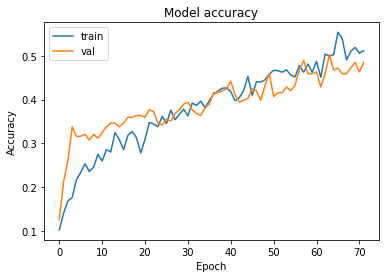

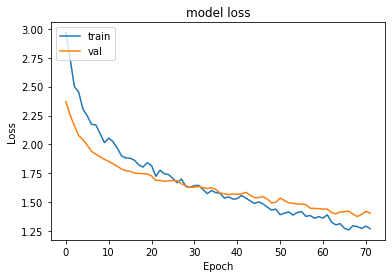

In [ ]:
plot_history(history)

Confusion Matrix: 



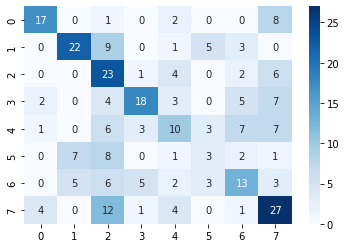

In [ ]:
y_pred = Model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print('Confusion Matrix: \n')
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.61      0.65        28
           1       0.65      0.55      0.59        40
           2       0.33      0.64      0.44        36
           3       0.64      0.46      0.54        39
           4       0.37      0.27      0.31        37
           5       0.21      0.14      0.17        22
           6       0.39      0.35      0.37        37
           7       0.46      0.55      0.50        49

    accuracy                           0.46       288
   macro avg       0.47      0.45      0.45       288
weighted avg       0.48      0.46      0.46       288



GENDER PREDICTION- MODEL CREATION

In [ ]:
le = LabelEncoder()

RAV_df['gender']= le.fit_transform(RAV_df['gender'])

In [ ]:
X = RAV_df.drop(['gender', 'emotion', 'labels'], axis = 1)
y = RAV_df['gender']

In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,-759.917847,75.788948,6.028998,14.562723,6.459432,14.636641,-2.999552,4.625813,-5.195350,-0.702961,-7.786034,-3.560928,2.184742,-1.828896,-0.347037,0.832212,-2.520894,-0.658892,2.920049,-1.937435,-3.031794,-0.292167,-0.244068,-0.540124,-2.956580,-2.104136,-1.400510,-0.925955,-3.723610,-1.993220,0.205182,-2.190074,-2.837190,0.461874,-1.021207,-1.413634,0.348101,-1.522349,-1.252681,-0.616518,...,0.000007,0.000006,0.000006,0.000006,0.000005,0.000007,0.000005,0.000003,0.000004,0.000004,0.000005,0.000006,0.000003,0.000004,0.000004,0.000004,0.000003,0.000004,0.000004,0.000002,0.000002,1.728236e-06,1.289864e-06,1.278671e-06,8.758655e-07,7.264676e-07,4.894324e-07,3.679957e-07,2.989512e-07,1.622806e-07,1.376438e-07,1.088035e-07,9.219798e-08,5.054346e-08,3.130356e-08,1.891648e-08,1.093055e-08,6.907234e-09,5.929377e-09,5.490418e-09
1,-735.006592,79.093056,8.141059,11.413560,5.174132,15.393293,-2.752063,2.964593,-5.388961,-1.691822,-5.852824,-4.043277,3.004652,-1.036605,-0.067745,0.088225,-2.209570,-1.455965,2.568242,-1.596300,-2.678672,-1.410864,0.118917,-0.127252,-2.847892,-1.771579,-1.886281,-0.791153,-3.215482,-2.180906,0.241240,-2.247438,-2.220091,-0.249406,-0.975884,-0.955849,-0.259040,-2.152876,-1.973072,-1.648132,...,0.000007,0.000004,0.000003,0.000003,0.000005,0.000004,0.000003,0.000003,0.000003,0.000004,0.000004,0.000003,0.000004,0.000006,0.000007,0.000007,0.000006,0.000004,0.000002,0.000002,0.000001,9.713349e-07,9.564819e-07,8.252334e-07,9.683692e-07,1.230503e-06,8.033527e-07,3.595680e-07,2.898434e-07,2.569258e-07,7.811629e-08,4.128243e-08,3.126313e-08,2.750857e-08,1.755317e-08,9.856551e-09,8.679062e-09,7.096063e-09,5.672045e-09,5.365027e-09
2,-726.217224,68.541420,3.293398,12.205300,5.510278,13.667410,-2.983829,3.098029,-3.310813,-1.564384,-7.861652,-2.124282,2.849204,-2.667806,0.959020,1.628167,-2.736689,0.254241,2.675377,-1.761165,-1.886474,-0.975620,-0.379437,0.400273,-3.044044,-2.901258,-0.109248,-0.863565,-3.333269,-1.978465,0.457081,-1.399109,-2.926855,0.013957,-0.490734,-0.570905,0.040399,-1.207217,-1.594982,-1.436487,...,0.000005,0.000004,0.000004,0.000005,0.000006,0.000004,0.000002,0.000003,0.000003,0.000003,0.000002,0.000002,0.000004,0.000006,0.000006,0.000005,0.000004,0.000003,0.000003,0.000002,0.000002,1.923959e-06,1.562696e-06,1.155648e-06,1.236189e-06,2.178529e-06,1.341962e-06,8.759328e-07,7.719471e-07,5.428048e-07,3.798515e-07,2.659118e-07,1.358990e-07,6.421450e-08,4.124923e-08,2.838078e-08,2.313626e-08,1.160476e-08,5.817900e-09,5.362134e-09
3,-710.959839,67.579185,5.783356,13.227695,6.194669,12.640195,-1.662046,5.663977,-4.953693,-3.484669,-7.417325,-1.927515,2.282990,-0.607773,0.171210,1.393946,-2.386732,-0.657544,1.749457,-0.492133,-3.015615,-0.982296,0.533741,0.270409,-2.364810,-2.673702,-1.400937,-0.044098,-2.158159,-1.575089,-0.402906,-1.325091,-2.506733,-0.183847,-0.639693,-0.547448,0.465640,-1.572787,-1.638369,-1.501148,...,0.000019,0.000013,0.000025,0.000033,0.000022,0.000022,0.000022,0.000012,0.000013,0.000015,0.000016,0.000048,0.000038,0.000030,0.000032,0.000029,0.000036,0.000021,0.000021,0.000019,0.000013,1.280474e-05,1.415233e-05,1.000641e-05,7.165249e-06,6.465661e-06,3.736069e-06,3.681650e-06,2.499252e-06,1.950656e-06,1.410576e-06,1.025075e-06,9.816289e-07,1.029304e-06,5.594787e-07,2.913279e-07,1.172367e-07,4.114702e-08,7.315270e-09,5.706893e-09
4,-733.524902,81.589859,4.863358,14.423687,5.267689,13.968560,-3.085617,7.173246,-4.821438,-0.967449,-6.250473,-3.866640,3.325519,-1.668072,1.981391,0.965025,-2.970167,0.925096,2.661871,-2.686702,-4.089703,-1.142779,-0.041476,0.639604,-4.437098,-1.978665,-1.668379,-0.129616,-2.648198,-1.740780,-0.243150,-1.499499,-3.442183,1.079488,-1.840691,-1.141296,-0.546892,-1.894406,-1.673830,-0.9

In [ ]:
y

0       1
1       1
2       1
3       1
4       1
       ..
1435    0
1436    0
1437    0
1438    0
1439    0
Name: gender, Length: 1440, dtype: int64

In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape)

(1152, 180) (288, 180)


In [ ]:
X_train

array([[-1.12265391, -0.98777284, -0.31543243, ..., -0.19631705,
        -0.21008011, -0.47964558],
       [ 0.94830173, -0.35419862, -1.35712354, ..., -0.12636526,
        -0.14523372, -0.06835586],
       [ 0.89584765, -1.52164942, -0.48280692, ..., -0.12092944,
        -0.1388496 , -0.08413044],
       ...,
       [ 0.19566166, -0.37304029, -0.51228444, ..., -0.1833235 ,
        -0.19899312, -0.43741407],
       [ 1.71623877, -1.11146245, -0.48034744, ...,  0.38732715,
         0.44532339,  0.48515332],
       [ 0.47692572, -0.64118618,  0.21002175, ..., -0.12733908,
        -0.12669008,  0.13400455]])

In [ ]:
Model = Sequential()

Model.add(Dense(128, input_shape = (X_train.shape[1],), activation = 'relu', kernel_initializer = 'he_normal'))
Model.add(Dropout(0.3))
Model.add(BatchNormalization())
Model.add(Dense(256, activation = 'relu', kernel_initializer = 'he_normal'))
Model.add(Dropout(0.3))
Model.add(BatchNormalization())
Model.add(Dense(256, activation = 'relu', kernel_initializer = 'he_normal'))
Model.add(Dropout(0.3))
Model.add(BatchNormalization())
Model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_normal'))
Model.add(Dropout(0.3))
Model.add(BatchNormalization())
Model.add(Dense(2, activation = 'softmax', kernel_initializer = 'he_normal'))

Model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 128)               23168     
                                                                 
 dropout_58 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_58 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_72 (Dense)            (None, 256)               33024     
                                                                 
 dropout_59 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_59 (Bat  (None, 256)              1024      
 chNormalization)                                    

In [ ]:
Model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
              loss='sparse_categorical_crossentropy',     # Multiclass classification
              metrics=['accuracy'])

In [ ]:
earlyStopping = callbacks.EarlyStopping(monitor='loss', patience=5)

chkpnt_path = 'Model/Model_checkpoint'
modelCheckpoint = callbacks.ModelCheckpoint(
    filepath = chkpnt_path,
    save_weights_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True
)

In [ ]:
history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, verbose = 1, validation_split = 0.2, callbacks = [earlyStopping, modelCheckpoint])

Epoch 1/100
19/19 [==============================] - 2s 22ms/step - loss: 0.6763 - accuracy: 0.6938 - val_loss: 0.4117 - val_accuracy: 0.8485
Epoch 2/100
19/19 [==============================] - 0s 10ms/step - loss: 0.3603 - accuracy: 0.8404 - val_loss: 0.2189 - val_accuracy: 0.9134
Epoch 3/100
19/19 [==============================] - 0s 10ms/step - loss: 0.2368 - accuracy: 0.9023 - val_loss: 0.1263 - val_accuracy: 0.9567
Epoch 4/100
19/19 [==============================] - 0s 16ms/step - loss: 0.1895 - accuracy: 0.9142 - val_loss: 0.0960 - val_accuracy: 0.9654
Epoch 5/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1613 - accuracy: 0.9327 - val_loss: 0.0643 - val_accuracy: 0.9740
Epoch 6/100
19/19 [==============================] - 0s 10ms/step - loss: 0.1101 - accuracy: 0.9555 - val_loss: 0.0551 - val_accuracy: 0.9784
Epoch 7/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1057 - accuracy: 0.9620 - val_loss: 0.0378 - val_accuracy: 0.9784
Epoch 8

In [ ]:
Model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 0.0206 - accuracy: 0.9896


[0.0206111092120409, 0.9895833134651184]

In [ ]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

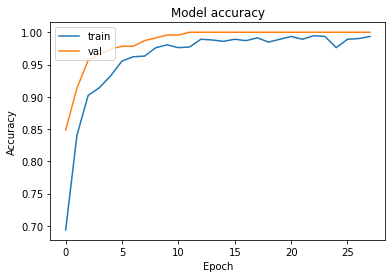

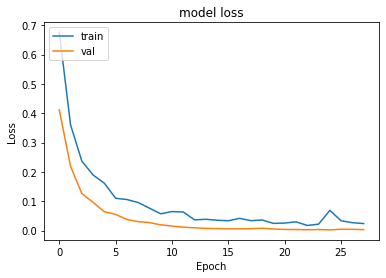

In [ ]:
plot_history(history)

Confusion Matrix: 



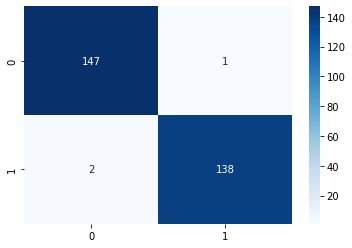

In [ ]:
y_pred = Model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print('Confusion Matrix: \n')
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       148
           1       0.99      0.99      0.99       140

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288



INFERENCE:

As observed from graph , there is no overfitting, train and val accuracy increasing similarly.
Early stopping have been used.
There are dips in training accuracy and validation accuracy.
Testing accuracy-0.9930555820465088.

In [ ]:
model = Sequential()
model.add(Dense(128, input_shape = (28*28,), activation = 'relu', kernel_initializer = 'random_uniform'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation = 'relu', kernel_initializer = 'random_uniform'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation = 'relu', kernel_initializer = 'random_uniform'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation = 'relu', kernel_initializer = 'random_uniform'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation = 'relu', kernel_initializer = 'random_uniform'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(2, activation = 'softmax', kernel_initializer = 'random_uniform'))
model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 128)               100480    
                                                                 
 dropout_62 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_62 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_77 (Dense)            (None, 64)                8256      
                                                                 
 dropout_63 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_63 (Bat  (None, 64)               256       
 chNormalization)                                    

In [ ]:
Model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
              loss='sparse_categorical_crossentropy',     # Multiclass classification
              metrics=['accuracy'])

In [ ]:
earlyStopping = callbacks.EarlyStopping(monitor='loss', patience=5)

chkpnt_path = 'Model/Model_checkpoint'
modelCheckpoint = callbacks.ModelCheckpoint(
    filepath = chkpnt_path,
    save_weights_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True
)

In [ ]:
history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, verbose = 1, validation_split = 0.2, callbacks = [earlyStopping, modelCheckpoint])

Epoch 1/100
19/19 [==============================] - 2s 21ms/step - loss: 0.0311 - accuracy: 0.9913 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0205 - accuracy: 0.9913 - val_loss: 8.3096e-04 - val_accuracy: 1.0000
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 4/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0207 - accuracy: 0.9935 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 5/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0133 - accuracy: 0.9946 - val_loss: 0.0085 - val_accuracy: 0.9913
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0455 - accuracy: 0.9837 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 7/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0190 - accuracy: 0.9935 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 8/

In [ ]:
Model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 0.0065 - accuracy: 0.9965


[0.006538120098412037, 0.9965277910232544]

In [ ]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

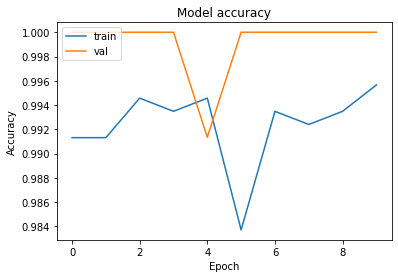

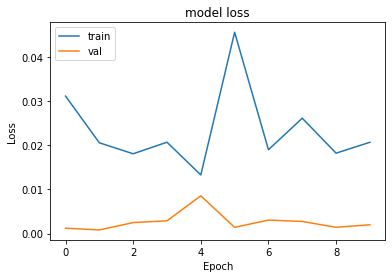

In [ ]:
plot_history(history)

Confusion Matrix: 



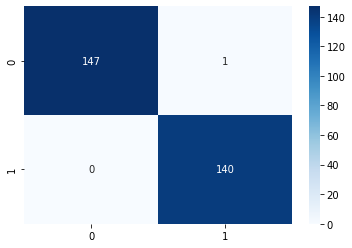

In [ ]:
y_pred = Model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print('Confusion Matrix: \n')
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       148
           1       0.99      1.00      1.00       140

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



INFERENCE:

As observed from graph , there is no overfitting, train and val accuracy increasing similarly.
Early stopping have been used.
There are dips in training accuracy and validation accuracy.
Testing accuracy-0.9930555820465088.

In [ ]:
le = LabelEncoder()

RAV_df['gender']= le.fit_transform(RAV_df['gender'])

In [ ]:
X = RAV_df.drop(['gender', 'emotion', 'labels'], axis = 1)
y = RAV_df['gender']

In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,-759.917847,75.788948,6.028998,14.562723,6.459432,14.636641,-2.999552,4.625813,-5.195350,-0.702961,-7.786034,-3.560928,2.184742,-1.828896,-0.347037,0.832212,-2.520894,-0.658892,2.920049,-1.937435,-3.031794,-0.292167,-0.244068,-0.540124,-2.956580,-2.104136,-1.400510,-0.925955,-3.723610,-1.993220,0.205182,-2.190074,-2.837190,0.461874,-1.021207,-1.413634,0.348101,-1.522349,-1.252681,-0.616518,...,0.000007,0.000006,0.000006,0.000006,0.000005,0.000007,0.000005,0.000003,0.000004,0.000004,0.000005,0.000006,0.000003,0.000004,0.000004,0.000004,0.000003,0.000004,0.000004,0.000002,0.000002,1.728236e-06,1.289864e-06,1.278671e-06,8.758655e-07,7.264676e-07,4.894324e-07,3.679957e-07,2.989512e-07,1.622806e-07,1.376438e-07,1.088035e-07,9.219798e-08,5.054346e-08,3.130356e-08,1.891648e-08,1.093055e-08,6.907234e-09,5.929377e-09,5.490418e-09
1,-735.006592,79.093056,8.141059,11.413560,5.174132,15.393293,-2.752063,2.964593,-5.388961,-1.691822,-5.852824,-4.043277,3.004652,-1.036605,-0.067745,0.088225,-2.209570,-1.455965,2.568242,-1.596300,-2.678672,-1.410864,0.118917,-0.127252,-2.847892,-1.771579,-1.886281,-0.791153,-3.215482,-2.180906,0.241240,-2.247438,-2.220091,-0.249406,-0.975884,-0.955849,-0.259040,-2.152876,-1.973072,-1.648132,...,0.000007,0.000004,0.000003,0.000003,0.000005,0.000004,0.000003,0.000003,0.000003,0.000004,0.000004,0.000003,0.000004,0.000006,0.000007,0.000007,0.000006,0.000004,0.000002,0.000002,0.000001,9.713349e-07,9.564819e-07,8.252334e-07,9.683692e-07,1.230503e-06,8.033527e-07,3.595680e-07,2.898434e-07,2.569258e-07,7.811629e-08,4.128243e-08,3.126313e-08,2.750857e-08,1.755317e-08,9.856551e-09,8.679062e-09,7.096063e-09,5.672045e-09,5.365027e-09
2,-726.217224,68.541420,3.293398,12.205300,5.510278,13.667410,-2.983829,3.098029,-3.310813,-1.564384,-7.861652,-2.124282,2.849204,-2.667806,0.959020,1.628167,-2.736689,0.254241,2.675377,-1.761165,-1.886474,-0.975620,-0.379437,0.400273,-3.044044,-2.901258,-0.109248,-0.863565,-3.333269,-1.978465,0.457081,-1.399109,-2.926855,0.013957,-0.490734,-0.570905,0.040399,-1.207217,-1.594982,-1.436487,...,0.000005,0.000004,0.000004,0.000005,0.000006,0.000004,0.000002,0.000003,0.000003,0.000003,0.000002,0.000002,0.000004,0.000006,0.000006,0.000005,0.000004,0.000003,0.000003,0.000002,0.000002,1.923959e-06,1.562696e-06,1.155648e-06,1.236189e-06,2.178529e-06,1.341962e-06,8.759328e-07,7.719471e-07,5.428048e-07,3.798515e-07,2.659118e-07,1.358990e-07,6.421450e-08,4.124923e-08,2.838078e-08,2.313626e-08,1.160476e-08,5.817900e-09,5.362134e-09
3,-710.959839,67.579185,5.783356,13.227695,6.194669,12.640195,-1.662046,5.663977,-4.953693,-3.484669,-7.417325,-1.927515,2.282990,-0.607773,0.171210,1.393946,-2.386732,-0.657544,1.749457,-0.492133,-3.015615,-0.982296,0.533741,0.270409,-2.364810,-2.673702,-1.400937,-0.044098,-2.158159,-1.575089,-0.402906,-1.325091,-2.506733,-0.183847,-0.639693,-0.547448,0.465640,-1.572787,-1.638369,-1.501148,...,0.000019,0.000013,0.000025,0.000033,0.000022,0.000022,0.000022,0.000012,0.000013,0.000015,0.000016,0.000048,0.000038,0.000030,0.000032,0.000029,0.000036,0.000021,0.000021,0.000019,0.000013,1.280474e-05,1.415233e-05,1.000641e-05,7.165249e-06,6.465661e-06,3.736069e-06,3.681650e-06,2.499252e-06,1.950656e-06,1.410576e-06,1.025075e-06,9.816289e-07,1.029304e-06,5.594787e-07,2.913279e-07,1.172367e-07,4.114702e-08,7.315270e-09,5.706893e-09
4,-733.524902,81.589859,4.863358,14.423687,5.267689,13.968560,-3.085617,7.173246,-4.821438,-0.967449,-6.250473,-3.866640,3.325519,-1.668072,1.981391,0.965025,-2.970167,0.925096,2.661871,-2.686702,-4.089703,-1.142779,-0.041476,0.639604,-4.437098,-1.978665,-1.668379,-0.129616,-2.648198,-1.740780,-0.243150,-1.499499,-3.442183,1.079488,-1.840691,-1.141296,-0.546892,-1.894406,-1.673830,-0.9

In [ ]:
y

0       1
1       1
2       1
3       1
4       1
       ..
1435    0
1436    0
1437    0
1438    0
1439    0
Name: gender, Length: 1440, dtype: int64

In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape)

(1152, 180) (288, 180)


In [ ]:
X_train

array([[-1.12265391, -0.98777284, -0.31543243, ..., -0.19631705,
        -0.21008011, -0.47964558],
       [ 0.94830173, -0.35419862, -1.35712354, ..., -0.12636526,
        -0.14523372, -0.06835586],
       [ 0.89584765, -1.52164942, -0.48280692, ..., -0.12092944,
        -0.1388496 , -0.08413044],
       ...,
       [ 0.19566166, -0.37304029, -0.51228444, ..., -0.1833235 ,
        -0.19899312, -0.43741407],
       [ 1.71623877, -1.11146245, -0.48034744, ...,  0.38732715,
         0.44532339,  0.48515332],
       [ 0.47692572, -0.64118618,  0.21002175, ..., -0.12733908,
        -0.12669008,  0.13400455]])

In [ ]:
model = Sequential()
model.add(Dense(128, input_shape = (28*28,), activation = 'relu', kernel_initializer = 'random_uniform'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation = 'relu', kernel_initializer = 'random_uniform'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation = 'relu', kernel_initializer = 'random_uniform'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation = 'relu', kernel_initializer = 'random_uniform'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation = 'relu', kernel_initializer = 'random_uniform'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(2, activation = 'softmax', kernel_initializer = 'random_uniform'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_82 (Dense)            (None, 128)               100480    
                                                                 
 dropout_67 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_67 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_83 (Dense)            (None, 64)                8256      
                                                                 
 dropout_68 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_68 (Bat  (None, 64)               256       
 chNormalization)                                    

In [ ]:
Model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
              loss='sparse_categorical_crossentropy',     # Multiclass classification
              metrics=['accuracy'])

In [ ]:
earlyStopping = callbacks.EarlyStopping(monitor='loss', patience=5)

chkpnt_path = 'Model/Model_checkpoint'
modelCheckpoint = callbacks.ModelCheckpoint(
    filepath = chkpnt_path,
    save_weights_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True
)

In [ ]:
history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, verbose = 1, validation_split = 0.2, callbacks = [earlyStopping, modelCheckpoint])

Epoch 1/100
19/19 [==============================] - 2s 20ms/step - loss: 0.0309 - accuracy: 0.9913 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0112 - accuracy: 0.9967 - val_loss: 8.6671e-04 - val_accuracy: 1.0000
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0147 - accuracy: 0.9957 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 4/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0115 - accuracy: 0.9946 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 5/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0147 - accuracy: 0.9957 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0146 - accuracy: 0.9967 - val_loss: 6.8219e-04 - val_accuracy: 1.0000
Epoch 7/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0081 - accuracy: 0.9967 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoc

In [ ]:
Model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 0.0071 - accuracy: 0.9965


[0.007119106128811836, 0.9965277910232544]

In [ ]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

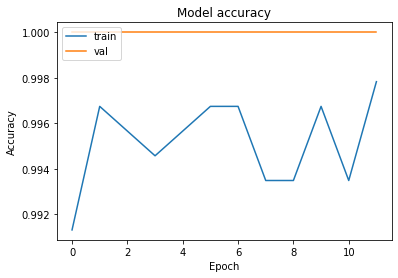

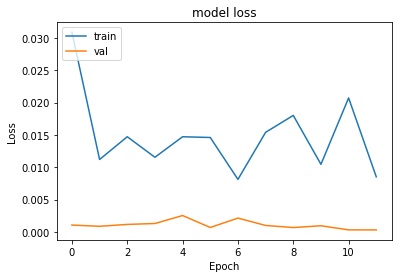

In [ ]:
plot_history(history)

Confusion Matrix: 



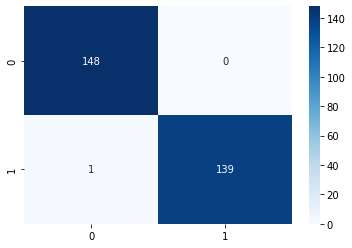

In [ ]:
y_pred = Model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print('Confusion Matrix: \n')
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       148
           1       1.00      0.99      1.00       140

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



INFERENCE:

As observed from graph , there is no overfitting, train and val accuracy increasing similarly.
Early stopping have been used.
There is a dip in training accuracy.
As the model ran for only 7 epoch we cannot conclude precisley from the graph.
Testing accuracy-0.9861111044883728.

HYPER PARAMTER TUNING

In [ ]:
!pip install keras-tuner --upgrade
import keras_tuner as kt
from tensorflow import keras

In [ ]:
# then we can go ahead and set the parameter space
p = {'first_neuron':[9,10,11],
     'hidden_layers':[0, 1, 2],
     'batch_size': [30],
     'epochs': [100],
     'dropout': [0],
     'kernel_initializer': ['uniform','normal'],
     'optimizer': ['Nadam', 'Adam'],
     'losses': ['binary_crossentropy'],
     'activation':['relu', 'elu'],
     'last_activation': ['sigmoid']}

In [ ]:
X = RAV_df.drop(['gender', 'emotion', 'labels'], axis = 1)
y = RAV_df['emotion']

In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=4)
clf.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [ ]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [ ]:
clf

GridSearchCV(cv=4, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [ ]:
y_true, y_pred = y_test , clf.predict(X_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

           0       0.53      0.64      0.58        28
           1       0.67      0.72      0.70        40
           2       0.51      0.56      0.53        36
           3       0.66      0.69      0.68        39
           4       0.67      0.54      0.60        37
           5       0.56      0.41      0.47        22
           6       0.43      0.54      0.48        37
           7       0.79      0.63      0.70        49

    accuracy                           0.60       288
   macro avg       0.60      0.59      0.59       288
weighted avg       0.62      0.60      0.61       288



Hence our model’s prediction of age, gender and emotion can be collectively used to take decisions regarding customer feedback and suggestions.